In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings

warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('train.csv' , parse_dates=['Order Date'])

In [6]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'] , dayfirst=True)

In [12]:
daily = df.groupby('Order Date')['Sales'].sum().sort_index().to_frame()
daily.index.name = 'date'
daily = daily.asfreq('D')
daily['Sales'] = daily['Sales'].fillna(0)
daily.head()

,Sales
date,
2015-01-03,16.448
2015-01-04,288.060
2015-01-05,19.536
2015-01-06,4407.100
2015-01-07,87.158


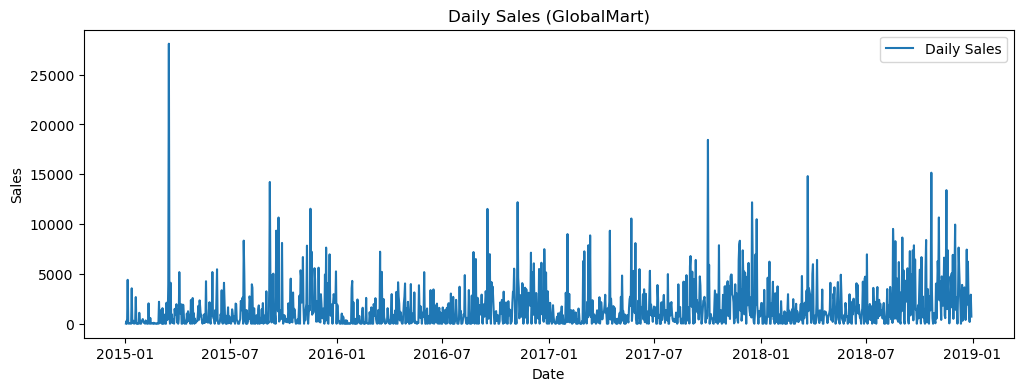

In [14]:
plt.figure(figsize=(12,4))
plt.plot(daily.index, daily['Sales'], label='Daily Sales')
plt.title('Daily Sales (GlobalMart)')
plt.xlabel('Date'); plt.ylabel('Sales')
plt.legend()
plt.show()


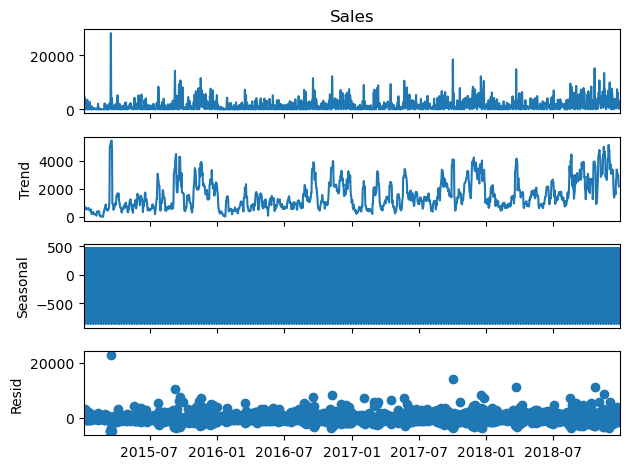

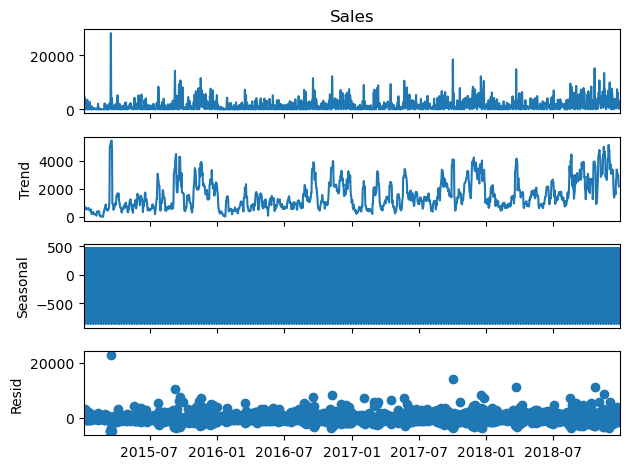

In [13]:
decom = seasonal_decompose(daily['Sales'] , model='additive' , period=7)
decom.plot()

In [15]:
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF statistic:', result[0])
    print('p-value:', result[1])
    for k,v in result[4].items():
        print('Critical Value (%s): %.3f' % (k, v))

adf_test(daily['Sales'])


ADF statistic: -4.926583375196258
p-value: 3.09489124587334e-05
Critical Value (1%): -3.435
Critical Value (5%): -2.864
Critical Value (10%): -2.568


In [16]:
# regular differencing
daily_diff = daily['Sales'].diff().dropna()
adf_test(daily_diff)

# seasonal differencing (if weekly seasonality)
daily_seas_diff = daily['Sales'].diff(7).dropna()
adf_test(daily_seas_diff)

# sometimes use both:
both = daily['Sales'].diff().diff(7).dropna()
adf_test(both)

ADF statistic: -14.37749911966676
p-value: 9.271421499634704e-27
Critical Value (1%): -3.435
Critical Value (5%): -2.864
Critical Value (10%): -2.568
ADF statistic: -12.091161072638906
p-value: 2.1210296833303954e-22
Critical Value (1%): -3.435
Critical Value (5%): -2.864
Critical Value (10%): -2.568
ADF statistic: -15.287407015246611
p-value: 4.491219371047769e-28
Critical Value (1%): -3.435
Critical Value (5%): -2.864
Critical Value (10%): -2.568


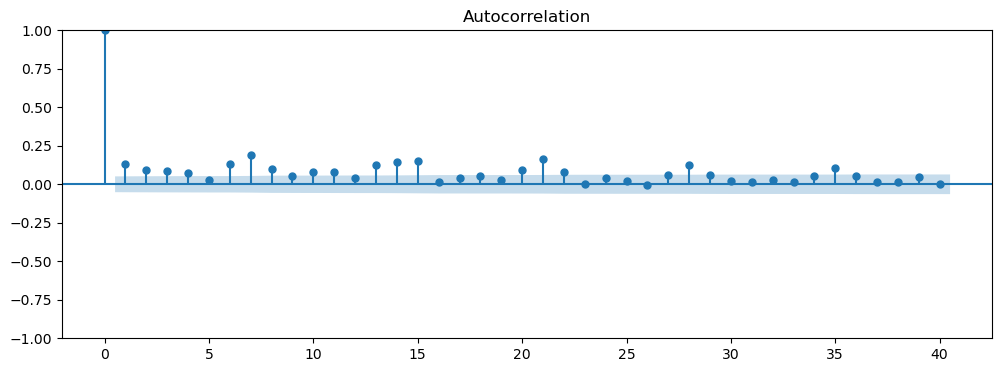

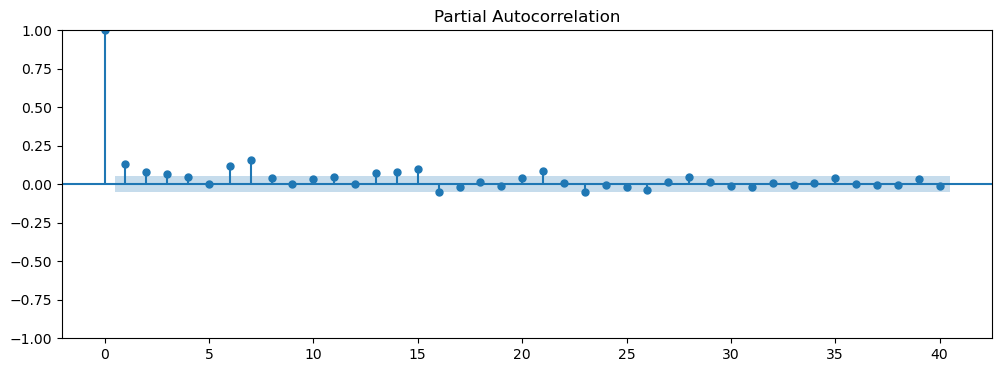

In [17]:
plt.figure(figsize=(12,4))
plot_acf(daily['Sales'].dropna(), lags=40, ax=plt.gca())
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(daily['Sales'].dropna(), lags=40, ax=plt.gca(), method='ywm')
plt.show()


In [46]:
# Example parameters (you will tune these)
order = (1,1,1)             # (p,d,q)
seasonal_order = (1,1,1,7)  # (P,D,Q,m) --> m=7 means weekly seasonality

# Fit the SARIMA model
model = SARIMAX(
    daily['Sales'], order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

C:\Users\FHCS\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                 1458
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13147.592
Date:                           Mon, 29 Sep 2025   AIC                          26305.185
Time:                                   00:52:09   BIC                          26331.581
Sample:                               01-03-2015   HQIC                         26315.035
                                    - 12-30-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0243      0.027      0.888      0.374      -0.029       0.078
ma.L1         -0.9570      0.010    -99.060

In [47]:
# Forecast next 30 days
forecast = results.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

print(forecast_mean)


2018-12-31    3382.026381
2019-01-01    3310.283649
2019-01-02    1781.968052
2019-01-03    1117.492418
2019-01-04    3164.871190
2019-01-05    3804.755175
2019-01-06    3142.189213
2019-01-07    3393.376932
2019-01-08    3345.169741
2019-01-09    1823.810189
2019-01-10    1158.654483
2019-01-11    3219.359422
2019-01-12    3844.727635
2019-01-13    3218.296808
2019-01-14    3412.739707
2019-01-15    3365.085057
2019-01-16    1843.888812
2019-01-17    1178.717140
2019-01-18    3239.734936
2019-01-19    3864.762364
2019-01-20    3239.179878
2019-01-21    3432.290584
2019-01-22    3384.648907
2019-01-23    1863.456495
2019-01-24    1198.284448
2019-01-25    3259.309589
2019-01-26    3884.329016
2019-01-27    3258.766447
2019-01-28    3451.845878
2019-01-29    3404.204504
Freq: D, Name: predicted_mean, dtype: float64


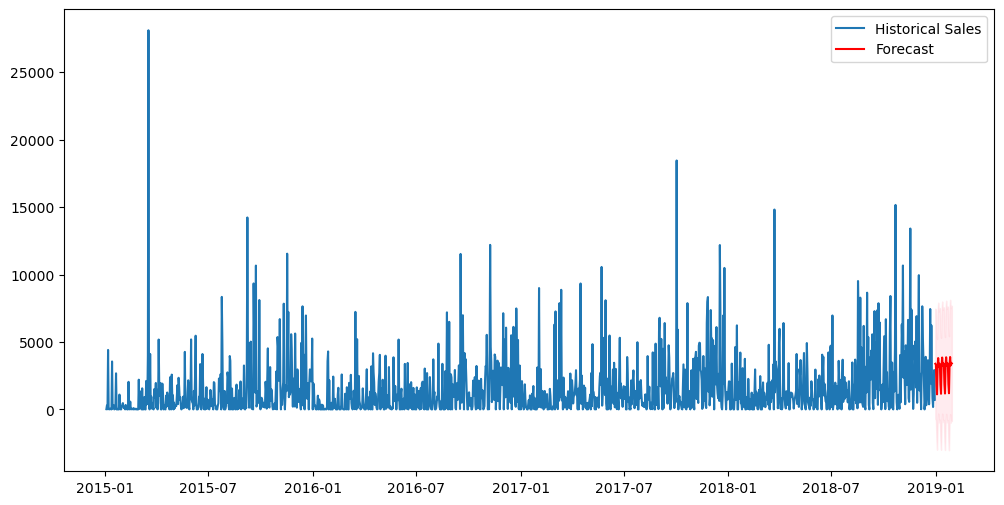

In [48]:
plt.figure(figsize=(12,6))
plt.plot(daily['Sales'], label='Historical Sales')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf.index,
                 forecast_conf.iloc[:,0],
                 forecast_conf.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

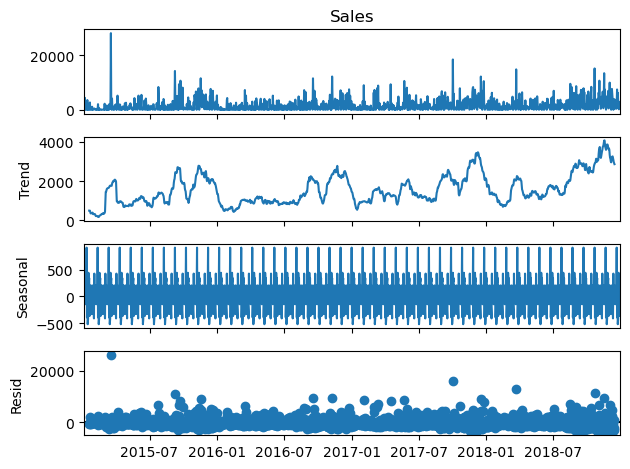

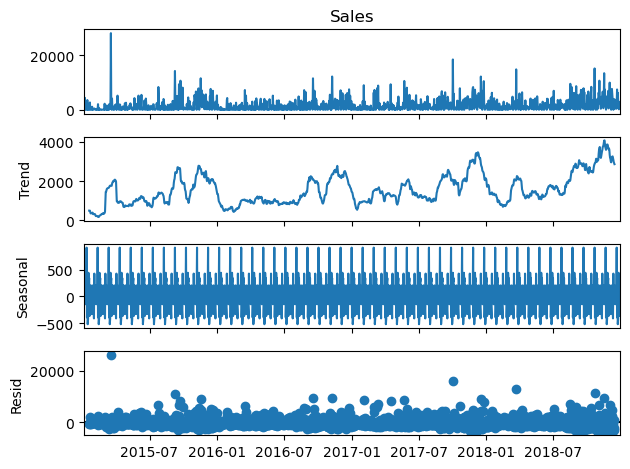

In [23]:
seasonal_decompose(daily['Sales'], model='additive', period=30).plot()


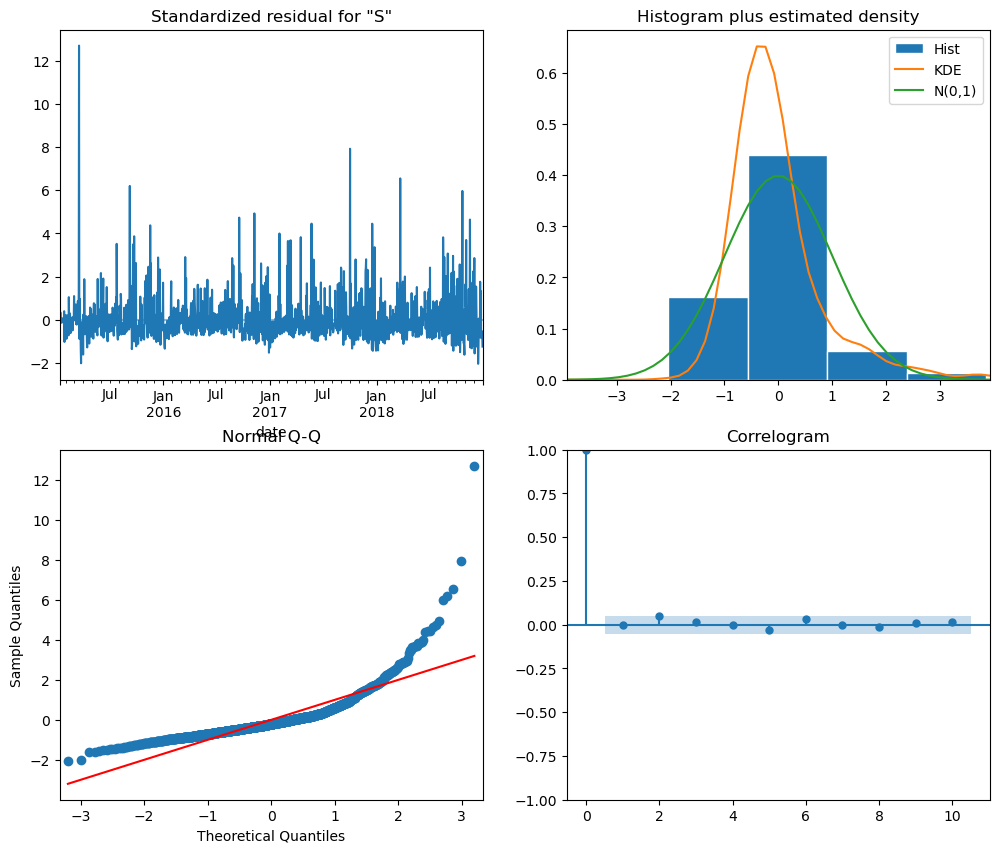

<Figure size 640x480 with 0 Axes>

In [30]:
results.plot_diagnostics(figsize=(12,10))
plt.show()
plt.tight_layout()